In [4]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import json
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

### Part 1 - Exploratory Data Analysis

In [5]:
# load as pandas dataframe
df = pd.read_json('C:/Users/sandhya.mukkamala/Downloads/1481053515_ultimate_challenge/ultimate_challenge/logins.json')

df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
# missing values
df.login_time.isna().value_counts()

False    93142
Name: login_time, dtype: int64

In [7]:
# sort by date/time
df = df.sort_values('login_time').reset_index(drop=True)
df.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


#### Aggregate these login counts based on 15minute time intervals

In [8]:
# set index
df.set_index('login_time', inplace=True)

# count column for logins
df['count_logins'] = 1

In [9]:
# login counts based on 15 minute time intervals
df = df.resample('15T').sum()
df.head()

,count_logins
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [10]:
print("The data is between the dates  {}  till  {} ".format(df.index[0], df.index[-1]))

The data is between the dates  1970-01-01 20:00:00  till  1970-04-13 18:45:00 


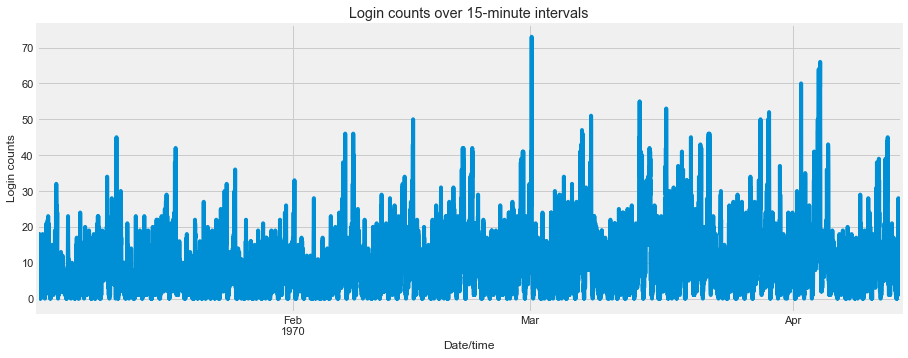

In [11]:
# login times over period of time
df.plot(legend=False)
plt.title('Login counts over 15-minute intervals')
plt.xlabel('Date/time')
plt.ylabel('Login counts')
plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0, hspace=0)
plt.show()

There is definitely a cyclical nature associated with these logins. We can also notice some days theer is a sudden increase of activity, for instance the one in beginning of March, where it reached more than 70 logins in a 15-minute interval.

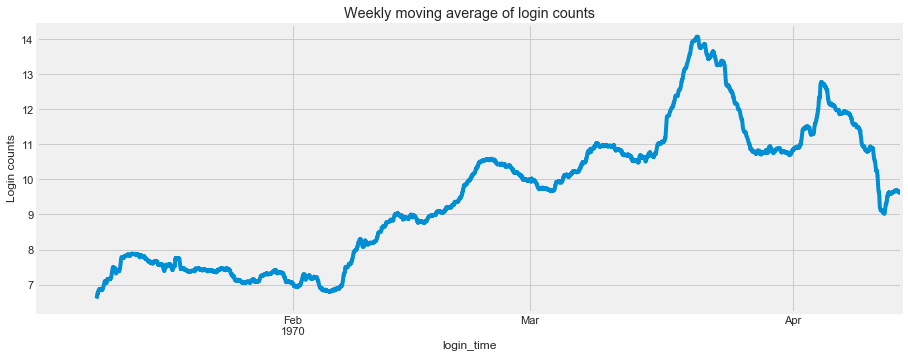

In [12]:
# weekly moving average
df.rolling(window=4*24*7).mean().plot(legend=False)
plt.title('Weekly moving average of login counts')
plt.ylabel('Login counts')
plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0, hspace=0)
plt.show()

When plotting the weekly moving average, we notice a clear upward tendency until about middle of March, to then decrease a bit until middle April.

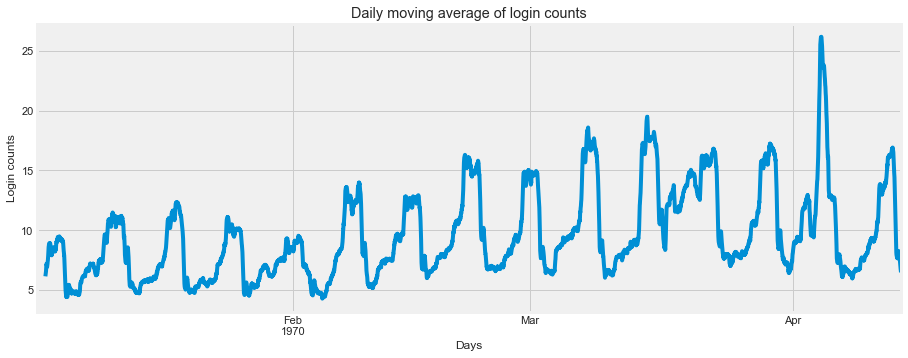

In [13]:
# daily moving average
df.rolling(window=4*24).mean().plot(legend=False)
plt.title('Daily moving average of login counts')
plt.xlabel('Days')
plt.ylabel('Login counts')
plt.subplots_adjust(left=0, bottom=0, right=2, top=1, wspace=0, hspace=0)
plt.show()

When analyzing the daily moving average, we see an upward tendency from January till April. The cyclical nature is even more evident now, where there is a clear pattern of some days where there are no average-15-minute login attempts and periodical increases until about 15-20.

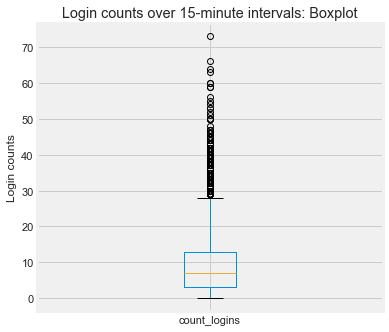

In [14]:
# boxplot to check if there is any outliers
df.boxplot()
plt.title('Login counts over 15-minute intervals: Boxplot')
plt.ylabel('Login counts')
plt.subplots_adjust(left=0, bottom=0, right=0.8, top=1, wspace=0, hspace=0)
plt.show()

There seems to be not much outliers only a couple, which can be observed in the above plots at the beginning of the March period where it crossed more than 70 logins

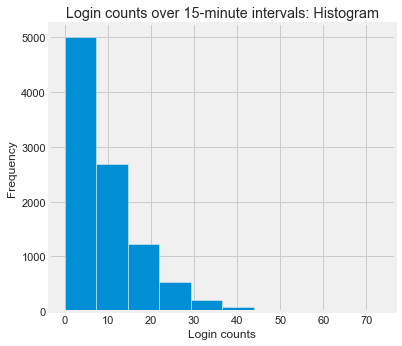

In [15]:
# histogram
df.plot(kind='hist', legend=False)
plt.title('Login counts over 15-minute intervals: Histogram')
plt.xlabel("Login counts")
plt.subplots_adjust(left=0, bottom=0, right=0.8, top=1, wspace=0, hspace=0)
plt.show()

Over 30 logins it starts to look as outliers, but as seen before, it is noticeable the increasing tendency. With maybe the exception, as noticed, of the middle of the interval range point in the beginning of March.

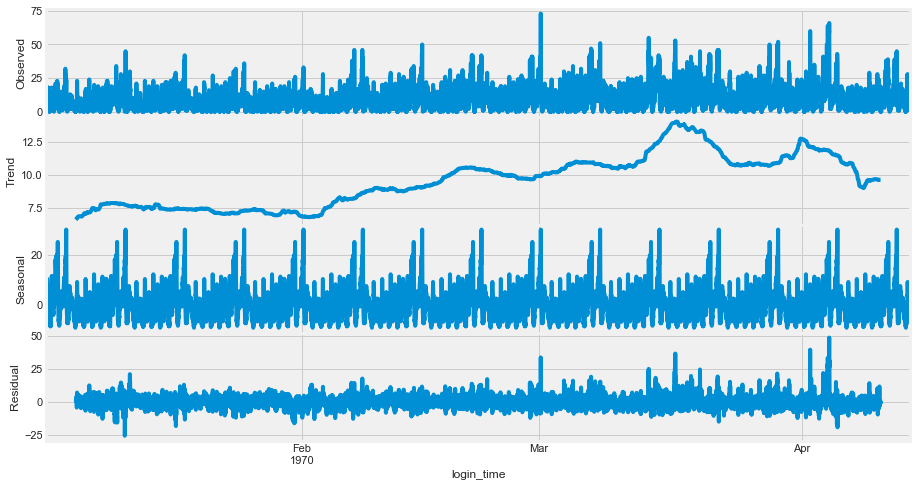

In [16]:
# time series decomposition
import statsmodels.api as sm

# decomposition - weekly
decomposition = sm.tsa.seasonal_decompose(df, model='additive', freq=4*24*7)  
decomposition.plot()

plt.subplots_adjust(left=0, bottom=-0.5, right=2, top=1, wspace=0, hspace=0)
plt.show()

It can be observed that there is seasonality, upward trend over the period summarize the described behaviour of login counts

### Part 2 - Experiment and metrics design

In the given information, it is not stated that there is no toll during the weekends. So, assuming that there is toll 24/7 it could be possible that people are travelling to Metropolis during day to work and returning to Gotham at night. Population in Gotham is more but work is based in Metropolis. Or it is possible that Metropolis is a tourist place but people are not staying there because of costs!
In contrast to this, during the weekend both the cities are seeing a similar activity as mentioned in the question. The activity could be very very less compared to weekdays which is not good to analyze. So, insufficient information is provided.
However considering reimbursing toll costs, then:

##### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I would choose activity as the key measure of success of this experiment as it provides a clear result i.e. if people are following the same trends even after reimbursing toll, then it is not worth it.

##### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:  
      a. how you will implement the experiment       
      b. what statistical test(s) you will conduct to verify the significance of the
      observation       
      c. how you would interpret the results and provide recommendations to the city
       operations team along with any caveats.       

If the sample size is more than 30, I would choose one sample z-test
- Sample should form a single treatment group. In this case people who received reimbursed toll
- Null hypothesis is that there is a difference in driver patterns after reimbursing
- Compute z-statistic
- find a confidence interval , use the standard normal table to find if the z-stat falls in the confidence interval. Accept  or reject the hypothesis

### Part 3 - Predictive modeling

##### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [17]:
with open('C:/Users/sandhya.mukkamala/Downloads/1481053515_ultimate_challenge/ultimate_challenge/ultimate_data_challenge.json') as f:
    data = json.load(f)
    
ultimate_df = pd.DataFrame(data)

In [18]:
# info
print(ultimate_df.info())

# head
ultimate_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB
None


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


#### Data Cleaning

In [19]:
# convert to datetime the following columns
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

In [20]:
# missing data - replace the missing ratings by the average values
ultimate_df['avg_rating_by_driver'].fillna(round(np.mean(ultimate_df['avg_rating_by_driver']), 1), inplace=True)
ultimate_df['avg_rating_of_driver'].fillna(round(np.mean(ultimate_df['avg_rating_of_driver']), 1), inplace=True)

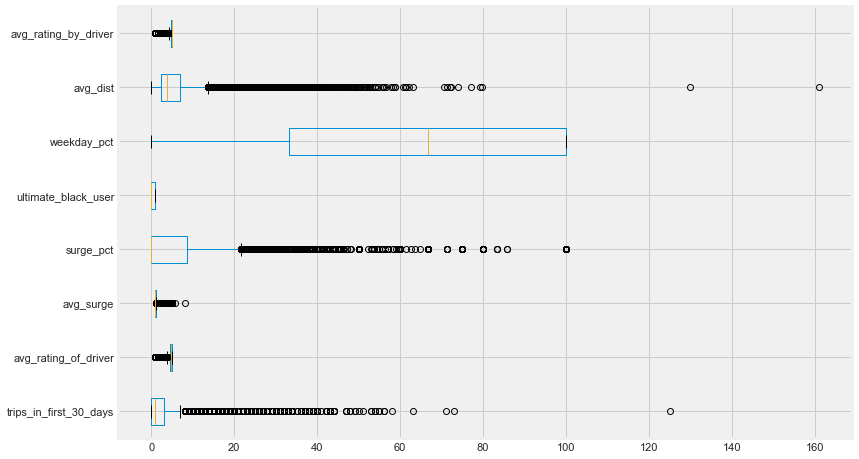

In [21]:
# check for outliers
ultimate_df.boxplot(vert=False)

plt.subplots_adjust(left=0, bottom=-0.5, right=1.7, top=1, wspace=0, hspace=0)
plt.show()

As there are only few, lets consider them for now as they might be a valid reason for those values

#### Exploratory Data Analysis

In [22]:
# describe
ultimate_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601306,1.074764,8.849536,60.926084,5.796827,4.778246
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445755
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [23]:
# user retained if they took a trip 30 days before the moment this data was gathered (let's assume it as last 'last_trip_date')
max_time = (ultimate_df['last_trip_date'].max() - timedelta(30))

print("The limit date for retain classification consideration is {}".format(max_time))

# create column "retained"
ultimate_df['retained'] = ultimate_df['last_trip_date'] >= max_time

ultimate_df.head()

The limit date for retain classification consideration is 2014-06-01 00:00:00


,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


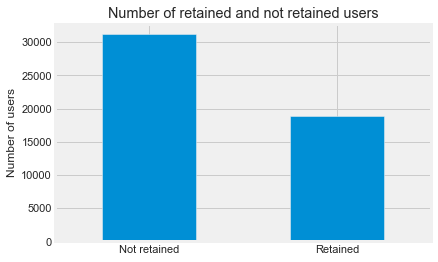

In [24]:
# barplot
ultimate_df['retained'].value_counts().plot(kind='bar')
plt.title('Number of retained and not retained users')
plt.xticks([0, 1], ['Not retained', 'Retained'], rotation=0)
plt.ylabel('Number of users')
plt.show()

In [25]:
# percentage of people retained
ultimate_df['retained'].value_counts()/len(ultimate_df)

False    0.62392
True     0.37608
Name: retained, dtype: float64

Nearly 38% of the users were considered to be retained.

In [26]:
# correlations with target
ultimate_df.corr(method='pearson')['retained'].sort_values(ascending=False)

retained                  1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.010667
avg_rating_by_driver     -0.026828
avg_dist                 -0.092780
Name: retained, dtype: float64

The number of trips and ultimate black during the first 30 days seem to be the most correlated variables with retainment.

In [27]:
ultimate_df[ultimate_df.retained == True].city.value_counts()

Winterfell        8213
King's Landing    6363
Astapor           4228
Name: city, dtype: int64

King's Landing has strong retention (more than 60%), although less users, when comparing to other cities, but still Winterfell is the city which retains more people in absolute terms.

In [28]:
# phone users that become retained
ultimate_df[ultimate_df.retained == True].phone.value_counts()

iPhone     15525
Android     3146
Name: phone, dtype: int64

Iphone users seem more predisposed to become retained for some reason.

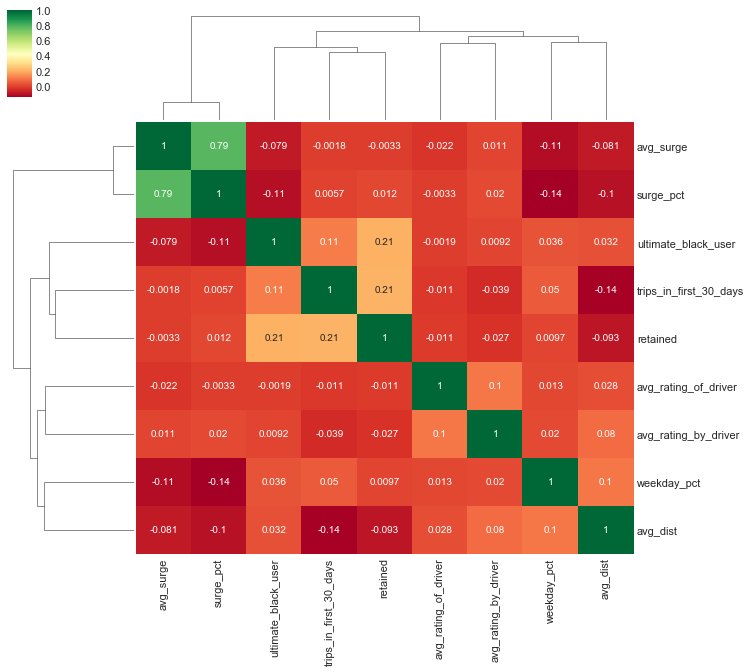

In [29]:
# correlation between variables
sns.clustermap(ultimate_df.corr(method='pearson'),cmap='RdYlGn', annot=True)
plt.show()

##### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

Since we are dealing with unbalanced data, let's test algorithms that can adapt to that. For linear models we might want to consider either 'avg_surge' or 'surge_pct', due to their high correlation --> this would cause interpretability problems. For the categorical variables, I will create dummy variables. Also exclude the variable related with the last trip date since it is not relevant to the problem.

In [30]:
# set index
ultimate_df.set_index('signup_date', inplace=True)
ultimate_df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
signup_date,,,,,,,,,,,,
2014-01-25,King's Landing,4,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
2014-01-29,Astapor,0,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2014-01-06,Astapor,3,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
2014-01-10,King's Landing,9,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
2014-01-27,Winterfell,14,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [31]:
# transform the data to operate with and split into train and test data

# target
y = ultimate_df['retained']

# exclude surge_pct and last_trip_date, get dummy variables and normalize
X = ultimate_df.drop(['surge_pct', 'last_trip_date', 'retained'], axis=1)
X = pd.get_dummies(X)
X = scale(X)


# Split into train (70%) and test (30%) sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [32]:
# set seed for reproducibility
SEED = 1

##### Logistic Regression

In [33]:
%%time
from sklearn.linear_model import LogisticRegression

# instantiate the model
clf_logreg = LogisticRegression(class_weight='balanced', solver='lbfgs', multi_class='auto', random_state=SEED)

# train the model
clf_logreg.fit(X_train, y_train)

Wall time: 116 ms


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
model = clf_logreg
model_name = 'LogisticRegression'

# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.6966

Confusion matrix:
 [[4481 1758]
 [1276 2485]]

Classification report:
               precision    recall  f1-score   support

       False       0.78      0.72      0.75      6239
        True       0.59      0.66      0.62      3761

    accuracy                           0.70     10000
   macro avg       0.68      0.69      0.68     10000
weighted avg       0.71      0.70      0.70     10000


AUC: 0.7531031376722634


##### RandomForestClassifier

In [35]:
%%time
from sklearn.ensemble import RandomForestClassifier

# instantiate the model
clf_rf = RandomForestClassifier(random_state=SEED, class_weight='balanced', n_estimators=10)

# train the model
clf_rf.fit(X_train, y_train)

Wall time: 765 ms


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=1, verbose=0, warm_start=False)

In [36]:
model = clf_rf
model_name = 'RandomForestClassifier'

# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.7512

Confusion matrix:
 [[5233 1006]
 [1482 2279]]

Classification report:
               precision    recall  f1-score   support

       False       0.78      0.84      0.81      6239
        True       0.69      0.61      0.65      3761

    accuracy                           0.75     10000
   macro avg       0.74      0.72      0.73     10000
weighted avg       0.75      0.75      0.75     10000


AUC: 0.8032029911596816


##### Extreme Gradient Boosting (XGBoost)

In [37]:
%%time
import xgboost as xgb

# instantiate the model
clf_xgb = xgb.XGBClassifier(random_state=SEED, n_estimators=10)

# train the model
clf_xgb.fit(X_train, y_train)

Wall time: 435 ms


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [38]:
model = clf_xgb
model_name = 'XGBClassifier'


# Model performance

# predict
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# score
print("Score:", model.score(X_test, y_test))

# Confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute and print AUC score
print("\nAUC: {}".format(roc_auc_score(y_test, y_pred_prob)))

Score: 0.7825

Confusion matrix:
 [[5362  877]
 [1298 2463]]

Classification report:
               precision    recall  f1-score   support

       False       0.81      0.86      0.83      6239
        True       0.74      0.65      0.69      3761

    accuracy                           0.78     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.78      0.78      0.78     10000


AUC: 0.8496007373402608


##### Model comparison

The XGBClassifier provided the best general results, with 78% accuracy and an AUC score of 0.84.

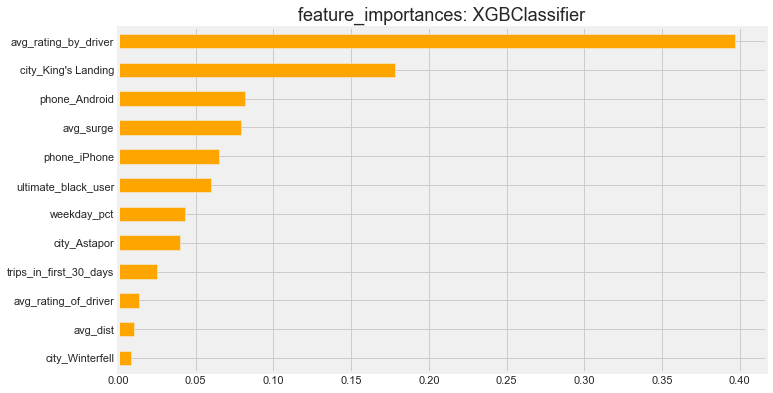

In [67]:
# X columns
X_columns = pd.get_dummies(ultimate_df.drop(['surge_pct', 'last_trip_date', 'retained'], axis=1)).columns

# Create a pd.Series of features feature_importances
feature_importances = pd.Series(data=clf_xgb.feature_importances_, index=X_columns)

# Sort feature_importances
feature_importances_sorted = feature_importances.sort_values()

# Draw a horizontal barplot of feature_importances_sorted
feature_importances_sorted.tail(100).plot(kind='barh', color='orange')
plt.title('feature_importances: {}'.format('XGBClassifier'), fontsize=18)
plt.subplots_adjust(left=0, bottom=-0.2, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

As Random Forest Classifier also got nearly best results, let us look at what features are important according to it

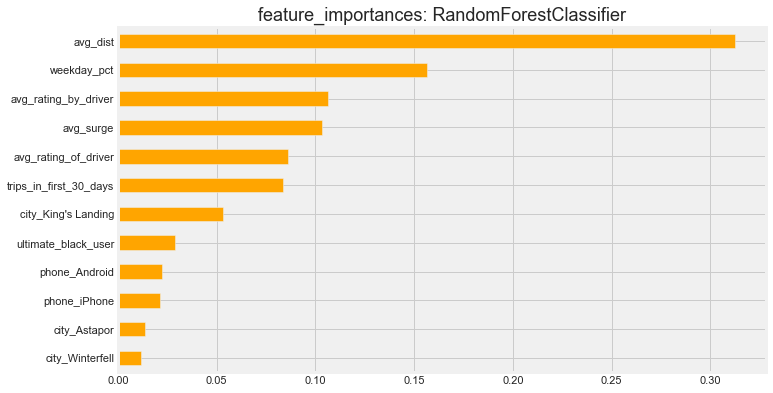

In [68]:
# X columns
X_columns = pd.get_dummies(ultimate_df.drop(['surge_pct', 'last_trip_date', 'retained'], axis=1)).columns

# Create a pd.Series of features feature_importances
feature_importances = pd.Series(data=clf_rf.feature_importances_, index=X_columns)

# Sort feature_importances
feature_importances_sorted = feature_importances.sort_values()

# Draw a horizontal barplot of feature_importances_sorted
feature_importances_sorted.tail(100).plot(kind='barh', color='orange')
plt.title('feature_importances: {}'.format('RandomForestClassifier'), fontsize=18)
plt.subplots_adjust(left=0, bottom=-0.2, right=1.5, top=1, wspace=0, hspace=0)
plt.show()

We could still improve the results by feature selection and hyper tuning

##### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice).

According to the algorithms we used to predict user retention, and with the previous EDA analysis made, we can identify some features that are relevant to take into consideration if Ultimate pretends to improve their retention success:

- Average rating by driver: explicit behavior important for retention, although surprisingly negatively correlated (not much).
- The average surge multiplier or, equivalently, the percent of trips taken with surge multiplier > 1: the smaller the better,   or otherwise it could scare users.
- The percent of the user's trips occurring during a weekday: most retentions were focused here.
- Take notice of users from the cities of Astapor and Winterfell: they are not getting as good retention when compared with       King's Landing users, at least.
- Android users do not get very effective retention for some reason.
- The average distance in miles per trip taken in the first 30 days after signup: focus on higher values, as a negative sign.


Also,should consider the number of trips and taking an ultimate black during the first 30 days as well, as positive and impactful correlations with retention.